In [17]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.deprecated.doc2vec import LabeledSentence
from gensim.models.word2vec import Word2Vec
from gensim.models.phrases import Phraser, Phrases
from gensim.parsing.porter import PorterStemmer
from gensim.parsing.preprocessing import STOPWORDS

import pandas as pd
import numpy as np
import string
import re
import random 
import os
import csv

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn import metrics
#from sklearn.grid_search import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import average_precision_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from modAL.uncertainty import entropy_sampling
from modAL.density import information_density

from scipy.stats import entropy

import gensim
import gensim.downloader as gensim_api
from numpy import asarray
from numpy import savetxt
from numpy import loadtxt

# Clean Data

In [25]:
porter = PorterStemmer()
punctuation_dictionary = {s:None for s in list(string.punctuation)}
#punctuation_dictionary["-"] = "_"

punctuation_translator = str.maketrans(punctuation_dictionary)

def text_cleaner(text, punctuation_translator, stemmer):
    text = str(text).translate(punctuation_translator)
    text = text.lower()
    text = re.split(' ',text)
    text = [porter.stem(word) for word in text]
    text = " ".join(text)
    return(text)

dat = pd.read_csv("20201115_all_paragraphs.csv")
dat["clean_text"] = dat["text"].apply(lambda x: text_cleaner(x, punctuation_translator, porter))


In [26]:
dat['speech_par_id'] = dat['Speech_id'].astype(str) + "_" + dat['par_id'].astype(str)

In [268]:
# dat[dat.duplicated(subset=['Speech_id', "par_id"], keep = False)]


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Speech_id,text,party,term,comp,populist_old_keywords,par_id,label,test,clean_text,phrased_text,doc_id,uniq_id,total_id
2383,2383,2383,2383,1822,"And I say to you: you know what we can do. You know how we will react to Mr. Khrushchev or to anyone else because we have been through the test. Now let us look at our opponent for a moment. What do we know about him? First of all, we know something about him as far as this campaign is concerned. On three occasions during our debates the American people have had an opportunity to see how he would have made a decision differently from the way the President of the United States has made that decision, decisions affecting the security of his country. And, so, you must test him, as you test us, by that record.",rep,1960,True,True,6,0.0,0.0,and i sai to you you know what we can do you know how we will react to mr khrushchev or to anyon els becaus we have been through the test now let us look at our oppon for a moment what do we know about him first of all we know someth about him as far as thi campaign is concern on three occas dure our debat the american peopl have had an opportun to see how he would have made a decis differ from the wai the presid of the unit state ha made that decis decis affect the secur of hi countri and so you must test him as you test us by that record,and i sai to you you know what we can do you know how we will react to mr_khrushchev or to anyon_els becaus we have been through the test now let us look_at our oppon for a moment what do we know about him first of all we know someth about him as far as thi campaign is concern on three occas dure our debat the american peopl have had an opportun to see how he would have made a decis differ from the wai the presid of the unit_state ha made that decis decis affect the secur of hi countri and so you must test him as you test us by that record,2383,2383_6,2383_6
2384,2384,2384,2383,1822,"And I say to you: you know what we can do. You know how we will react to Mr. Khrushchev or to anyone else because we have been through the test. Now let us look at our opponent for a moment. What do we know about him? First of all, we know something about him as far as this campaign is concerned. On three occasions during our debates the American people have had an opportunity to see how he would have made a decision differently from the way the President of the United States has made that decision, decisions affecting the security of his country. And, so, you must test him, as you test us, by that record.",rep,1960,True,True,6,0.0,1.0,and i sai to you you know what we can do you know how we will react to mr khrushchev or to anyon els becaus we have been through the test now let us look at our oppon for a moment what do we know about him first of all we know someth about him as far as thi campaign is concern on three occas dure our debat the american peopl have had an opportun to see how he would have made a decis differ from the wai the presid of the unit state ha made that decis decis affect the secur of hi countri and so you must test him as you test us by that record,and i sai to you you know what we can do you know how we will react to mr_khrushchev or to anyon_els becaus we have been through the test now let us look_at our oppon for a moment what do we know about him first of all we know someth about him as far as thi campaign is concern on three occas dure our debat the american peopl have had an opportun to see how he would have made a decis differ from the wai the presid of the unit_state ha made that decis decis affect the secur of hi countri and so you must test him as you test us by that record,2384,2384_6,2384_6
9649,9649,9649,9648,2877,"But my opponent, as a senator, personally led the fight against having a shuttle program at all. He called it a horrible waste. Well, we support the space shuttle, and we've committed America to meet a great challenge--to build a manned space center out

In [27]:
phrases1 = Phrases(map(lambda x: x.split(), dat["clean_text"].tolist())) #bigram
phrases2 = Phrases(phrases1[map(lambda x: x.split(), dat["clean_text"].tolist())]) #trigram
dat["phrased_text"] = dat["clean_text"].apply(lambda x: " ".join(phrases2[phrases1[x.split()]]))

In [28]:
dat['phrased_text'][0] #check result

'when we start talk_about the economi it best that we get right to the point jimmi_carter promis the american peopl he would give them an inflat_rate of four percent and an unemploy_rate of four percent there no nice wai to sai it he just plain broke hi promis and by do so ha shatter the hope of million and million of american who ar strap to the wall by thi unstabl economi'

# Doc2Vec

In [30]:
docs = list(zip(dat["phrased_text"].tolist(), dat["speech_par_id"].tolist()))


## Define an iterator to feed documents and tags to Doc2Vec
class Sentences(object):
    def __init__(self, docs):
        self.docs = docs
    def __iter__(self):
        for doc in self.docs:
            yield TaggedDocument(words=str(doc[0]).split(), tags=[doc[1]])

## Train and save models
model = Doc2Vec(Sentences(docs), vector_size=150, window=10, min_count=10, negative=10, epochs=20, dm=0, dbow_words=1)

In [93]:
print(len(model.docvecs))
# model.save("doc2vec_wordvecs.model")
print(len(docs))
print(len(dat))

71827
71827
71827


In [160]:
#model.wv.most_similar('trump') #check the model
dat.text.isnull().values.any()

False

In [52]:
model = Word2Vec.load("doc2vec_wordvecs.model") 

# hyper parameter tuning (on populism dimension)

In [54]:
dat = pd.read_csv("20220131_all_paragraphs_2020_added_missings_added.csv")

annotated = pd.read_csv("All_annotated_data_populism.csv")
file = "/Users/yuchenluo/Desktop/Measure_RadicalDiscourse/codes/Prediction_of_test_populism/" + "20220209_Grid_10239_1e-05_5_4_1.csv"
test = pd.read_csv(file)
train = annotated[~annotated['speech_par_id'].isin(test["speech_par_id"])]
test = test[test['speech_par_id'].isin(dat['speech_par_id'])]
train = train[train['speech_par_id'].isin(dat['speech_par_id'])] # make sure annotated data and the original df match

# merge test and train sets back onto the total df
dat['test'] = np.where(dat['speech_par_id'].isin(test["speech_par_id"]), 1, 0)
dat['train'] = np.where(dat['speech_par_id'].isin(train["speech_par_id"]), 1, 0)
dat = dat.merge(annotated[["speech_par_id", "pred_class"]], how = "left", on = "speech_par_id")
# so that the order of rows are the same with the embeddings

test_set = np.asarray([model.docvecs[i] for i in dat[dat['test'] == 1].index.tolist()])
train_set = np.asarray([model.docvecs[i] for i in dat[dat['train']== 1].index.tolist()])




/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [55]:
# tuning for RFC
parameters = {'n_estimators':[500, 1000, 5000], 'max_depth':[3, 5, 10], "max_features": ["sqrt", 0.2, 0.5]}
rfc = RandomForestClassifier()
clf = GridSearchCV(rfc, parameters,scoring = "average_precision")
clf.fit(train_set, dat[dat['train']==1].pred_class)
print(clf.best_params_) 

{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 500}


In [56]:
#for BalancedRandomForest
balanced_rfc = BalancedRandomForestClassifier()
balanced_clf = GridSearchCV(balanced_rfc, parameters,scoring = "average_precision")
balanced_clf.fit(train_set, dat[dat['train']==1].pred_class)
print(balanced_clf.best_params_) 

{'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 5000}


In [48]:
# for tf-idf
annotated = pd.read_csv("All_annotated_data_populism.csv")
file = "/Users/yuchenluo/Desktop/Measure_RadicalDiscourse/codes/Prediction_of_test_populism/" + "Grid_18983_1e-05_5_4_1.csv"
test = pd.read_csv(file)
train = annotated[~annotated['speech_par_id'].isin(test["speech_par_id"])]
test = test[test['speech_par_id'].isin(dat['speech_par_id'])]
train = train[train['speech_par_id'].isin(dat['speech_par_id'])] 

parameters = {'clf__n_estimators':[500, 1000, 5000], 'clf__max_depth':[3, 5, 10], "clf__max_features": ["sqrt", 0.2, 0.5]}

# pipeline BOW, tfidf and RF
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', RandomForestClassifier()),
#                      ('grid',GridSearchCV )
                    ])
## Fit the model to the training set
text_clf = GridSearchCV(text_clf, parameters, scoring = "average_precision")
text_clf.fit(train['text'], train['pred_class'])

print(text_clf.best_params_) 


{'clf__max_depth': 3, 'clf__max_features': 'sqrt', 'clf__n_estimators': 5000}


In [58]:
# for Word2Vec
annotated = pd.read_csv("All_annotated_data_populism.csv")
file = "/Users/yuchenluo/Desktop/Measure_RadicalDiscourse/codes/Prediction_of_test_populism/" + "20220209_Grid_10239_1e-05_5_4_1.csv"
test = pd.read_csv(file)
train = annotated[~annotated['speech_par_id'].isin(test["speech_par_id"])]
test = test[test['speech_par_id'].isin(dat['speech_par_id'])]
train = train[train['speech_par_id'].isin(dat['speech_par_id'])] 

avg_embeddings = loadtxt('avg_embeddings.csv', delimiter=',')

dat = pd.read_csv("20220131_all_paragraphs_2020_added_missings_added.csv")
dat = dat.merge(annotated[["speech_par_id", "pred_class"]], how = "left", on = "speech_par_id")
# attach train/test set to original df
train_id = train['speech_par_id']
test_id = test['speech_par_id']    
dat['test'] = np.where(dat['speech_par_id'].isin(test_id), 1, 0)
dat['train'] = np.where(dat['speech_par_id'].isin(train_id), 1, 0)
# get the embeddings to train/test set
train_vec = np.asarray([avg_embeddings[i] for i in dat[dat['speech_par_id'].isin(train_id)].index.tolist()])
test_vec = np.asarray([avg_embeddings[i] for i in dat[dat['speech_par_id'].isin(test_id)].index.tolist()])

parameters = {'n_estimators':[500, 1000, 5000], 'max_depth':[3, 5, 10], "max_features": ["sqrt", 0.2, 0.5]}

text_clf = RandomForestClassifier()
text_clf = GridSearchCV(text_clf, parameters, scoring = "average_precision")
text_clf.fit(train_vec,  dat[dat['train']==1].pred_class)
## Fit the model to the training set
text_clf.fit(train_vec, train['pred_class'])

print(text_clf.best_params_) 


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


{'max_depth': 10, 'max_features': 0.2, 'n_estimators': 5000}


In [60]:
# for pretrained

annotated = pd.read_csv("All_annotated_data_populism.csv")
file = "/Users/yuchenluo/Desktop/Measure_RadicalDiscourse/codes/Prediction_of_test_populism/" + "20220209_Grid_10239_1e-05_5_4_1.csv"
test = pd.read_csv(file)
train = annotated[~annotated['speech_par_id'].isin(test["speech_par_id"])]
test = test[test['speech_par_id'].isin(dat['speech_par_id'])]
train = train[train['speech_par_id'].isin(dat['speech_par_id'])] 

avg_embeddings = loadtxt('avg_embeddings_pretrained.csv', delimiter=',')

dat = pd.read_csv("20220131_all_paragraphs_2020_added_missings_added.csv")
dat = dat.merge(annotated[["speech_par_id", "pred_class"]], how = "left", on = "speech_par_id")
# attach train/test set to original df
train_id = train['speech_par_id']
test_id = test['speech_par_id']    
dat['test'] = np.where(dat['speech_par_id'].isin(test_id), 1, 0)
dat['train'] = np.where(dat['speech_par_id'].isin(train_id), 1, 0)
# get the embeddings to train/test set
train_vec = np.asarray([avg_embeddings[i] for i in dat[dat['speech_par_id'].isin(train_id)].index.tolist()])
test_vec = np.asarray([avg_embeddings[i] for i in dat[dat['speech_par_id'].isin(test_id)].index.tolist()])

parameters = {'n_estimators':[500, 1000, 5000], 'max_depth':[3, 5, 10], "max_features": ["sqrt", 0.2, 0.5]}

text_clf = RandomForestClassifier()
text_clf = GridSearchCV(text_clf, parameters,scoring = "average_precision")
text_clf.fit(train_vec,  dat[dat['train']==1].pred_class)
## Fit the model to the training set
text_clf.fit(train_vec, train['pred_class'])

print(text_clf.best_params_) 

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 5000}


In [112]:
# # test balanced RFC
# brfc = BalancedRandomForestClassifier(n_estimators=500, sampling_strategy = "all")
# ## Fit the model to the training set
# brfc.fit(train_set, dat[dat['train']==1].pred_class)
# #PR AUC
# preds = brfc.predict_proba(test_set)
# lr_precision, lr_recall, _ = precision_recall_curve(dat[dat['test']==1].pred_class,  preds[:,1].tolist())
# lr_auc = auc(lr_recall, lr_precision)
# print(lr_auc)

# confusion = confusion_matrix(dat[dat['test']==1].pred_class, brfc.predict(test_set))
# print(confusion)


0.25315970839427054
[[372  60]
 [  5   8]]


# Tf-idf RF

In [49]:
auc_scores = []
pr_auc = []

dat = pd.read_csv("20220115_all_paragraphs_2020_added.csv")
annotated = pd.read_csv("All_annotated_data_populism.csv")
dat = dat.merge(annotated[["speech_par_id", "pred_class"]], how = "left", on = "speech_par_id")

for filename in os.listdir("/Users/yuchenluo/Desktop/Measure_RadicalDiscourse/codes/Prediction_of_test_populism/"):
    ## load the test set 
    file = "/Users/yuchenluo/Desktop/Measure_RadicalDiscourse/codes/Prediction_of_test_populism/" + "/" + filename
    test = pd.read_csv(file)
    train = annotated[~annotated['speech_par_id'].isin(test["speech_par_id"])]
    test = test[test['speech_par_id'].isin(dat['speech_par_id'])]
    train = train[train['speech_par_id'].isin(dat['speech_par_id'])] # make sure annotated data and the original df match
    # pipeline BOW, tfidf and RF
    text_clf = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf', RandomForestClassifier(n_estimators=5000, max_depth=3,max_features='sqrt', random_state=0, class_weight="balanced")),
                        ])
    ## Fit the model to the training set
    text_clf = text_clf.fit(train['text'], train['pred_class'])
    ## Predict out-of-sample on the test set and compute AUC
    preds = text_clf.predict_proba(test['text'])
    fpr_d2v, tpr_d2v, thresholds_d2v = metrics.roc_curve(test['true_class'], preds[:,1], pos_label=1)
    auc_scores = auc_scores + [metrics.auc(fpr_d2v, tpr_d2v)]
    #PR AUC
    lr_precision, lr_recall, _ = precision_recall_curve(test['true_class'],  preds[:,1].tolist())
    lr_auc = auc(lr_recall, lr_precision)
    pr_auc = pr_auc + [lr_auc]
    print("AUC: "+str(metrics.auc(fpr_d2v, tpr_d2v)))
    print("PR AUC: " + str(lr_auc))
    
print("Mean AUC: " + str(np.mean(auc_scores)))
print("Mean PR AUC: " + str(np.mean(pr_auc)))

confusion = confusion_matrix(test['true_class'],text_clf.predict(test['text']) )
print(confusion)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


AUC: 0.8183760683760684
PR AUC: 0.4099387076061983
AUC: 0.789351851851852
PR AUC: 0.28408610669642087
AUC: 0.8258547008547008
PR AUC: 0.29658462741510083
AUC: 0.8790954415954416
PR AUC: 0.24166553788645612
AUC: 0.8121438746438747
PR AUC: 0.2371099270586384
AUC: 0.8634660003569518
PR AUC: 0.20223642652850507
AUC: 0.8636039886039887
PR AUC: 0.2988073565082227
AUC: 0.875534188034188
PR AUC: 0.20573956596797255
AUC: 0.8214031339031339
PR AUC: 0.33433771788325756
AUC: 0.7993233618233618
PR AUC: 0.23500406321122436
AUC: 0.8735754985754987
PR AUC: 0.36340568553304586
AUC: 0.7895770123148314
PR AUC: 0.307076441160218
AUC: 0.7836538461538461
PR AUC: 0.3233606453619609
AUC: 0.916488603988604
PR AUC: 0.39123024464246303
AUC: 0.8306623931623932
PR AUC: 0.35567951197796366
AUC: 0.8126780626780626
PR AUC: 0.18919262024473796
AUC: 0.7508903133903133
PR AUC: 0.32068438681575795
AUC: 0.7857905982905984
PR AUC: 0.31005780611027267
AUC: 0.8538105413105413
PR AUC: 0.16526768957962348
AUC: 0.88220596109227

In [51]:
with open("populism_pr_auc_tfidf.csv", "w") as csvfile:
    csvwriter = csv.writer(csvfile)
    for row in pr_auc:
        csvwriter.writerow([row])    
    
with open("populism_tfidf.csv", "w") as csvfile:
    csvwriter = csv.writer(csvfile)
    for row in auc_scores:
        csvwriter.writerow([row])

# Local Word2Vec RF

In [64]:
auc_scores = []
pr_auc = []

dat = pd.read_csv("20220115_all_paragraphs_2020_added.csv")
annotated = pd.read_csv("All_annotated_data_round_1_populism_20220209.csv")
dat = dat.merge(annotated[["speech_par_id", "pred_class"]], how = "left", on = "speech_par_id")
avg_embeddings = loadtxt('avg_embeddings.csv', delimiter=',')

for filename in os.listdir("/Users/yuchenluo/Desktop/Measure_RadicalDiscourse/codes/Prediction_of_test_populism/"):
    ## load the test set 
    file = "/Users/yuchenluo/Desktop/Measure_RadicalDiscourse/codes/Prediction_of_test_populism/" + "/" + filename
    test = pd.read_csv(file)
    train = annotated[~annotated['speech_par_id'].isin(test["speech_par_id"])]
    test = test[test['speech_par_id'].isin(dat['speech_par_id'])]
    train = train[train['speech_par_id'].isin(dat['speech_par_id'])] # make sure annotated data and the original df match
    # attach train/test set to original df
    train_id = train['speech_par_id']
    test_id = test['speech_par_id']    
    dat['test'] = np.where(dat['speech_par_id'].isin(test_id), 1, 0)
    dat['train'] = np.where(dat['speech_par_id'].isin(train_id), 1, 0)
    # get the embeddings to train/test set
    train_vec = np.asarray([avg_embeddings[i] for i in dat[dat['speech_par_id'].isin(train_id)].index.tolist()])
    test_vec = np.asarray([avg_embeddings[i] for i in dat[dat['speech_par_id'].isin(test_id)].index.tolist()])
    ## Fit the model to the training set
    text_clf = RandomForestClassifier(n_estimators=500, max_depth=3, random_state=0, max_features = "sqrt", class_weight="balanced")
    text_clf.fit(train_vec,  dat[dat['train']==1].pred_class) # use the original df to match the order
    ## Predict out-of-sample on the test set and compute AUC
    preds = text_clf.predict_proba(test_vec)
    fpr_d2v, tpr_d2v, thresholds_d2v = metrics.roc_curve(dat[dat['test']==1].pred_class, preds[:,1], pos_label=1)
    auc_scores = auc_scores + [metrics.auc(fpr_d2v, tpr_d2v)]
    #PR AUC
    lr_precision, lr_recall, _ = precision_recall_curve(dat[dat['test']==1].pred_class,  preds[:,1].tolist())
    lr_auc = auc(lr_recall, lr_precision)
    pr_auc = pr_auc + [lr_auc]
    print("AUC: "+str(metrics.auc(fpr_d2v, tpr_d2v)))
    print("PR AUC: " + str(lr_auc))
    
print("Mean AUC: " + str(np.mean(auc_scores)))
print("Mean PR AUC: " + str(np.mean(pr_auc)))

confusion = confusion_matrix(dat[dat['test']==1].pred_class,text_clf.predict(test_vec) )
print(confusion)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


AUC: 0.9063001963233982
PR AUC: 0.19409213682681498
AUC: 0.8616452991452992
PR AUC: 0.3347844618575158
AUC: 0.8308404558404558
PR AUC: 0.19176735805502287
AUC: 0.8194444444444444
PR AUC: 0.15960836196070954
AUC: 0.8365384615384616
PR AUC: 0.285567635214586
AUC: 0.8862179487179488
PR AUC: 0.24573000721238103
AUC: 0.9031339031339032
PR AUC: 0.2977111648426485
AUC: 0.9148860398860399
PR AUC: 0.5108814284213604
AUC: 0.9100481884704623
PR AUC: 0.372626307551024
AUC: 0.9262820512820512
PR AUC: 0.4578361157168603
AUC: 0.8940527065527066
PR AUC: 0.2510078963930677
AUC: 0.8365384615384616
PR AUC: 0.22289429669195532
AUC: 0.8568376068376069
PR AUC: 0.09863432060078005
AUC: 0.8527421652421652
PR AUC: 0.23288212267608027
AUC: 0.8249643874643875
PR AUC: 0.2382532910805894
AUC: 0.8929843304843305
PR AUC: 0.4567946246967879
AUC: 0.9241452991452992
PR AUC: 0.4022113923132845
AUC: 0.869480056980057
PR AUC: 0.3566825420457933
AUC: 0.8869301994301995
PR AUC: 0.23152790520374028
AUC: 0.8932714617169375
PR

In [62]:
with open("populism_pr_auc_w2v.csv", "w") as csvfile:
    csvwriter = csv.writer(csvfile)
    for row in pr_auc:
        csvwriter.writerow([row])    
    
with open("populism_auc_w2v.csv", "w") as csvfile:
    csvwriter = csv.writer(csvfile)
    for row in auc_scores:
        csvwriter.writerow([row])

# Pretrained Word2Vec


In [63]:
auc_scores = []
pr_auc = []

dat = pd.read_csv("20220115_all_paragraphs_2020_added.csv")
annotated = pd.read_csv("All_annotated_data_populism.csv")
dat = dat.merge(annotated[["speech_par_id", "pred_class"]], how = "left", on = "speech_par_id")
avg_embeddings = loadtxt('avg_embeddings_pretrained.csv', delimiter=',')

for filename in os.listdir("/Users/yuchenluo/Desktop/Measure_RadicalDiscourse/codes/Prediction_of_test_populism/"):
    ## load the test set 
    file = "/Users/yuchenluo/Desktop/Measure_RadicalDiscourse/codes/Prediction_of_test_populism/" + "/" + filename
    test = pd.read_csv(file)
    train = annotated[~annotated['speech_par_id'].isin(test["speech_par_id"])]
    test = test[test['speech_par_id'].isin(dat['speech_par_id'])]
    train = train[train['speech_par_id'].isin(dat['speech_par_id'])] # make sure annotated data and the original df match
    # attach train/test set to original df
    train_id = train['speech_par_id']
    test_id = test['speech_par_id']    
    dat['test'] = np.where(dat['speech_par_id'].isin(test_id), 1, 0)
    dat['train'] = np.where(dat['speech_par_id'].isin(train_id), 1, 0)
    # get the embeddings to train/test set
    train_vec = np.asarray([avg_embeddings[i] for i in dat[dat['speech_par_id'].isin(train_id)].index.tolist()])
    test_vec = np.asarray([avg_embeddings[i] for i in dat[dat['speech_par_id'].isin(test_id)].index.tolist()])
    ## Fit the model to the training set
    text_clf = RandomForestClassifier(n_estimators=500, max_depth=3, random_state=0, max_features = "sqrt", class_weight="balanced")
    text_clf.fit(train_vec,  dat[dat['train']==1].pred_class) # use the original df to match the order
    ## Predict out-of-sample on the test set and compute AUC
    preds = text_clf.predict_proba(test_vec)
    fpr_d2v, tpr_d2v, thresholds_d2v = metrics.roc_curve(dat[dat['test']==1].pred_class, preds[:,1], pos_label=1)
    auc_scores = auc_scores + [metrics.auc(fpr_d2v, tpr_d2v)]
    #PR AUC
    lr_precision, lr_recall, _ = precision_recall_curve(dat[dat['test']==1].pred_class,  preds[:,1].tolist())
    lr_auc = auc(lr_recall, lr_precision)
    pr_auc = pr_auc + [lr_auc]
    print("AUC: "+str(metrics.auc(fpr_d2v, tpr_d2v)))
    print("PR AUC: " + str(lr_auc))
    
print("Mean AUC: " + str(np.mean(auc_scores)))
print("Mean PR AUC: " + str(np.mean(pr_auc)))

confusion = confusion_matrix(dat[dat['test']==1].pred_class,text_clf.predict(test_vec) )
print(confusion)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


KeyboardInterrupt: 

In [26]:
with open("populism_pr_auc_pretrained.csv", "w") as csvfile:
    csvwriter = csv.writer(csvfile)
    for row in pr_auc:
        csvwriter.writerow([row])    
    
with open("populism_auc_pretrained.csv", "w") as csvfile:
    csvwriter = csv.writer(csvfile)
    for row in auc_scores:
        csvwriter.writerow([row])

# Doc2Vec RF

In [3]:
auc_scores_d2v = []
pr_auc = []
accuracy_scores_d2v = []

dat = pd.read_csv("20220115_all_paragraphs_2020_added.csv")

model = Word2Vec.load("doc2vec_wordvecs.model") 
annotated = pd.read_csv("All_annotated_data_populism.csv")
dat = dat.merge(annotated[["speech_par_id", "pred_class"]], how = "left", on = "speech_par_id")

for filename in os.listdir("/Users/yuchenluo/Desktop/Measure_RadicalDiscourse/codes/Prediction_of_test_populism/"):
    ## load the test set 
    file = "/Users/yuchenluo/Desktop/Measure_RadicalDiscourse/codes/Prediction_of_test_populism/" + "/" + filename
    test = pd.read_csv(file)
    train = annotated[~annotated['speech_par_id'].isin(test["speech_par_id"])]
    test = test[test['speech_par_id'].isin(dat['speech_par_id'])]
    train = train[train['speech_par_id'].isin(dat['speech_par_id'])] # make sure annotated data and the original df match
    # merge test and train sets back onto the total df
    dat['test'] = np.where(dat['speech_par_id'].isin(test["speech_par_id"]), 1, 0)
    dat['train'] = np.where(dat['speech_par_id'].isin(train["speech_par_id"]), 1, 0)
    # so that teh order of rows are the same with the embeddings
    test_set = np.asarray([model.docvecs[i] for i in dat[dat['test'] == 1].index.tolist()])
    train_set = np.asarray([model.docvecs[i] for i in dat[dat['train']== 1].index.tolist()])
    ## Initialize a random forest classifier
    gbc = RandomForestClassifier(n_estimators=500, max_depth=3, random_state=0, max_features = "sqrt", class_weight="balanced")
    ## Fit the model to the training set
    gbc.fit(train_set, dat[dat['train']==1].pred_class)
    ## Predict out-of-sample on the test set and compute AUC
    preds = gbc.predict_proba(test_set)
    fpr_d2v, tpr_d2v, thresholds_d2v = metrics.roc_curve(dat[dat['test']==1].pred_class, preds[:,1], pos_label=1)
    auc_scores_d2v = auc_scores_d2v + [metrics.auc(fpr_d2v, tpr_d2v)]
    #PR AUC
    lr_precision, lr_recall, _ = precision_recall_curve(dat[dat['test']==1].pred_class,  preds[:,1].tolist())
    lr_auc = auc(lr_recall, lr_precision)
    pr_auc = pr_auc + [lr_auc]
    print("AUC: "+str(metrics.auc(fpr_d2v, tpr_d2v)))
    accuracy_d2v = metrics.accuracy_score(dat[dat['test']==1].pred_class, gbc.predict(test_set))
    accuracy_scores_d2v = accuracy_scores_d2v + [accuracy_d2v]
    print("Accuracy: " + str(accuracy_d2v))
    print("PR_AUC: " + str(lr_auc))

print("Mean AUC: " + str(np.mean(auc_scores_d2v)))
print("Mean Accuracy: " + str(np.mean(accuracy_scores_d2v)))

confusion = confusion_matrix(dat[dat['test']==1].pred_class, gbc.predict(test_set))
print(confusion)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


AUC: 0.9216524216524216
Accuracy: 0.9685393258426966
PR_AUC: 0.27355540942177103
AUC: 0.873397435897436
Accuracy: 0.9662921348314607
PR_AUC: 0.20825762795191552
AUC: 0.8668091168091169
Accuracy: 0.9707865168539326
PR_AUC: 0.20304822005261253
AUC: 0.9225427350427351
Accuracy: 0.9640449438202248
PR_AUC: 0.18747421597419112
AUC: 0.8728632478632479
Accuracy: 0.9730337078651685
PR_AUC: 0.2574036765521344
AUC: 0.9330715688024271
Accuracy: 0.9752252252252253
PR_AUC: 0.3810561115722895
AUC: 0.9155982905982907
Accuracy: 0.9662921348314607
PR_AUC: 0.27001887859149215
AUC: 0.9013532763532763
Accuracy: 0.9707865168539326
PR_AUC: 0.363115852275887
AUC: 0.9228988603988604
Accuracy: 0.9730337078651685
PR_AUC: 0.36628873064698664
AUC: 0.8648504273504274
Accuracy: 0.9685393258426966
PR_AUC: 0.28922565985300597
AUC: 0.9172008547008548
Accuracy: 0.9662921348314607
PR_AUC: 0.2442976856132296
AUC: 0.9518115295377476
Accuracy: 0.9707207207207207
PR_AUC: 0.4357343700789092
AUC: 0.9323361823361823
Accuracy: 0

In [11]:
with open("populism_pr_auc.csv", "w") as csvfile:
    csvwriter = csv.writer(csvfile)
    for row in pr_auc:
        csvwriter.writerow([row])
    
    
with open("populism_auc.csv", "w") as csvfile:
    csvwriter = csv.writer(csvfile)
    for row in auc_scores_d2v:
        csvwriter.writerow([row])

In [4]:
print("Standard Deviation: " + str(np.std(auc_scores_d2v)))
print("Standard Deviation: " + str(np.std(accuracy_scores_d2v)))
print(sum(pr_auc)/len(pr_auc))

Standard Deviation: 0.02571281527486323
Standard Deviation: 0.003314339257060044
0.33613701213203134


In [6]:
auc_scores_balanced = []
pr_auc_balanced = []
accuracy_scores_balanced = []


dat = pd.read_csv("20201115_all_paragraphs.csv")
dat['speech_par_id'] = dat['Speech_id'].astype(str) + "_" + dat['par_id'].astype(str)
# X = np.asarray([model.docvecs[i] for i in label_dat.index.tolist()])
# Y = np.asarray(label_dat['label'].tolist(), dtype="int")
model = Word2Vec.load("doc2vec_wordvecs.model") 
annotated = pd.read_csv("All_annotated_data_populism.csv")
dat = dat.merge(annotated[["speech_par_id", "pred_class"]], how = "left", on = "speech_par_id")


for filename in os.listdir("/Users/yuchenluo/Desktop/Measure_RadicalDiscourse/codes/Prediction_of_test_populism/"):
    ## load the test set 
    file = "/Users/yuchenluo/Desktop/Measure_RadicalDiscourse/codes/Prediction_of_test_populism/" + "/" + filename
    test = pd.read_csv(file)
    train = annotated[~annotated['speech_par_id'].isin(test["speech_par_id"])]
    test = test[test['speech_par_id'].isin(dat['speech_par_id'])]
    train = train[train['speech_par_id'].isin(dat['speech_par_id'])] # make sure annotated data and the original df match
    # merge test and train sets back onto the total df
    dat['test'] = np.where(dat['speech_par_id'].isin(test["speech_par_id"]), 1, 0)
    dat['train'] = np.where(dat['speech_par_id'].isin(train["speech_par_id"]), 1, 0)
    # so that teh order of rows are the same with the embeddings
    test_set = np.asarray([model.docvecs[i] for i in dat[dat['test'] == 1].index.tolist()])
    train_set = np.asarray([model.docvecs[i] for i in dat[dat['train']== 1].index.tolist()])
    ## Initialize a random forest classifier
    brfc = BalancedRandomForestClassifier(n_estimators=5000, max_depth=10, random_state=0, max_features = "sqrt")
    ## Fit the model to the training set
    brfc.fit(train_set, dat[dat['train']==1].pred_class)
    ## Predict out-of-sample on the test set and compute AUC
    preds = brfc.predict_proba(test_set)
    fpr, tpr, thresholds = metrics.roc_curve(dat[dat['test']==1].pred_class, preds[:,1], pos_label=1)
    auc_scores_balanced = auc_scores_balanced + [metrics.auc(fpr, tpr)]
    #PR AUC
    lr_precision, lr_recall, _ = precision_recall_curve(dat[dat['test']==1].pred_class,  preds[:,1].tolist())
    lr_auc = auc(lr_recall, lr_precision)
    pr_auc_balanced = pr_auc_balanced + [lr_auc]
    print("AUC: "+str(metrics.auc(fpr, tpr)))
    accuracy_balanced = metrics.accuracy_score(dat[dat['test']==1].pred_class, brfc.predict(test_set))
    accuracy_scores_balanced = accuracy_scores_balanced + [accuracy_balanced]
    print("Accuracy: " + str(accuracy_balanced))
    print("PR_AUC: " + str(lr_auc))

print("Mean AUC: " + str(np.mean(auc_scores_balanced)))
print("Mean Accuracy: " + str(np.mean(accuracy_scores_balanced)))

AUC: 0.9439102564102564
Accuracy: 0.8471910112359551
PR_AUC: 0.3810566932086169
AUC: 0.8941417378917379
Accuracy: 0.8292134831460675
PR_AUC: 0.25445705122000833
AUC: 0.8875534188034188
Accuracy: 0.8426966292134831
PR_AUC: 0.24450144094600113
AUC: 0.932514245014245
Accuracy: 0.8269662921348314
PR_AUC: 0.21494119197020228
AUC: 0.9066061253561254
Accuracy: 0.8584269662921349
PR_AUC: 0.30855018580652277
AUC: 0.9484204890237371
Accuracy: 0.8288288288288288
PR_AUC: 0.4380828468913973
AUC: 0.9197827635327636
Accuracy: 0.8539325842696629
PR_AUC: 0.271415807857777
AUC: 0.9250356125356126
Accuracy: 0.8741573033707866
PR_AUC: 0.3982344188310565
AUC: 0.9407051282051283
Accuracy: 0.8539325842696629
PR_AUC: 0.5031707146418541
AUC: 0.8874643874643875
Accuracy: 0.8471910112359551
PR_AUC: 0.329087831188469
AUC: 0.9155982905982907
Accuracy: 0.8696629213483146
PR_AUC: 0.2846791801019254
AUC: 0.9644833125111547
Accuracy: 0.8513513513513513
PR_AUC: 0.5596221760943898
AUC: 0.9460470085470086
Accuracy: 0.865

In [124]:
print("Mean ROC-AUC: " + str(np.mean(auc_scores_d2v)))
print("Mean Accuracy: " + str(np.mean(accuracy_scores_d2v)))
print("Mean PR_AUC: " + str(np.mean(pr_auc)))

Mean ROC-AUC: 0.9056987493472414
Mean Accuracy: 0.9715146607281437
Mean PR_AUC: 0.3260486611864


In [121]:
confusion = confusion_matrix(dat[dat['test']==1].pred_class, brfc.predict(test_set))
print(confusion)

[[368  64]
 [  1  12]]


In [123]:
print("Mean ROC-AUC: " + str(np.mean(auc_scores_balanced)))
print("Mean Accuracy: " + str(np.mean(accuracy_scores_balanced)))
print("Mean PR_AUC: " + str(np.mean(pr_auc_balanced)))

Mean ROC-AUC: 0.92611854484921
Mean Accuracy: 0.8472257650909337
Mean PR_AUC: 0.39700123955248284


In [12]:
with open("populism_pr_auc_balanced.csv", "w") as csvfile:
    csvwriter = csv.writer(csvfile)
    for row in pr_auc_balanced:
        csvwriter.writerow([row])

    
with open("populism_auc_balanced.csv", "w") as csvfile:
    csvwriter = csv.writer(csvfile)
    for row in auc_scores_balanced:
        csvwriter.writerow([row])
    


In [70]:
# learner = ActiveLearner(
#     estimator= BalancedRandomForestClassifier(n_estimators=5000, max_depth=10, random_state=0,oob_score = True),
#     query_strategy=entropy_sampling,
#     X_training=X_training, y_training=Y_training
# )


# X_pool = np.asarray([model.docvecs[i] for i in clas_dat.index[clas_dat['label'].isnull()].tolist()])
unlabelled = clas_dat[clas_dat['label'].isnull()]
unlabelled = unlabelled.reindex(range(0, len(unlabelled)))
# # len(unlabelled)
# query_idx, query_inst = learner.query(X_pool, 69290)
# print(query_idx)


# unlabelled.loc[query_idx.tolist(), ]




NameError: name 'clas_dat' is not defined

In [178]:
clas_dat.loc[query_idx, 'label'] = 0

# Define new training set
x_new_train = np.asarray([model.docvecs[i] for i in query_idx])
y_new_train = np.asarray(clas_dat.loc[query_idx, 'label'].tolist(), dtype="int")
X_training = np.append(X_training,x_new_train, axis = 0)
Y_training = np.append(Y_training,y_new_train, axis = 0)

print(X_training.shape)
Y_training

(577, 150)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [179]:
gbc = RandomForestClassifier(bootstrap=True,criterion='gini',max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=5000,
            oob_score=False,
            random_state=1,
            verbose=0, warm_start=False, class_weight= 'balanced')
gbc = CalibratedClassifierCV(gbc, cv=5, method="sigmoid")
gbc.fit(X_training, Y_training)

print(metrics.recall_score(Y_test, gbc.predict(X_test)))

preds = gbc.predict_proba(X_test)
probs = preds[:, 1].tolist()
precision, recall, thresholds = precision_recall_curve(Y_test, probs)


pr_auc = auc(recall, precision)

fpr_d2v, tpr_d2v, thresholds_d2v = metrics.roc_curve(Y_test, preds[:,1], pos_label=1)
accuracy_d2v = metrics.accuracy_score(Y_test, gbc.predict(X_test), normalize=True)


print("AUC: "+ str(metrics.auc(fpr_d2v, tpr_d2v)))
print("Accuracy: " + str(accuracy_d2v))
print(pr_auc)

predicted = gbc.predict(X_test)
confusion = confusion_matrix(Y_test, predicted)
print(confusion)

0.23809523809523808
AUC: 0.8209406713505074
Accuracy: 0.9430255402750491
0.18980469365834815
[[475  13]
 [ 16   5]]


In [180]:

learner = ActiveLearner(
    estimator= BalancedRandomForestClassifier(n_estimators=5000, max_depth=10, random_state=0,oob_score = True),
    query_strategy=entropy_sampling,
    X_training=X_training, y_training=Y_training
)


X_pool = np.asarray([model.docvecs[i] for i in clas_dat.index[clas_dat['label'].isnull()].tolist()])
query_idx, query_inst = learner.query(X_pool,10)
query_idx

clas_dat.loc[query_idx, 'text']


51594                                                                                                                                                  And the good thing about so many of us here—and I know, I speak for Jay and Bey—is we remember what it's like not having anything, and we know people who were just as talented as us that didn't get the same break, the same chance. We remember some of our parents or grandparents who came here as immigrants and got a little bit of help along the way to go to that school or be able to start that first business. We understand that—as Michelle said as well as anybody could—those of us who have been blessed with success and been able to walk through those doors of opportunity, we don't slam the door behind us. We prop it open. We make it easier for those who follow to succeed as well.
42106                                                                                                                                                            

In [181]:
clas_dat.loc[query_idx, 'label'] = 0
clas_dat.loc[39767, 'label'] = 1


# Define new training set
x_new_train = np.asarray([model.docvecs[i] for i in query_idx])
y_new_train = np.asarray(clas_dat.loc[query_idx, 'label'].tolist(), dtype="int")
X_training = np.append(X_training,x_new_train, axis = 0)
Y_training = np.append(Y_training,y_new_train, axis = 0)

print(X_training.shape)
Y_training

(587, 150)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [182]:
gbc = RandomForestClassifier(bootstrap=True,criterion='gini',max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=5000,
            oob_score=False,
            random_state=1,
            verbose=0, warm_start=False, class_weight= 'balanced')
gbc = CalibratedClassifierCV(gbc, cv=5, method="sigmoid")
gbc.fit(X_training, Y_training)

print(metrics.recall_score(Y_test, gbc.predict(X_test)))

preds = gbc.predict_proba(X_test)
probs = preds[:, 1].tolist()
precision, recall, thresholds = precision_recall_curve(Y_test, probs)


pr_auc = auc(recall, precision)

fpr_d2v, tpr_d2v, thresholds_d2v = metrics.roc_curve(Y_test, preds[:,1], pos_label=1)
accuracy_d2v = metrics.accuracy_score(Y_test, gbc.predict(X_test), normalize=True)


print("AUC: "+ str(metrics.auc(fpr_d2v, tpr_d2v)))
print("Accuracy: " + str(accuracy_d2v))
print(pr_auc)

predicted = gbc.predict(X_test)
confusion = confusion_matrix(Y_test, predicted)
print(confusion)

0.19047619047619047
AUC: 0.8207455113192818
Accuracy: 0.9410609037328095
0.1862084018740162
[[475  13]
 [ 17   4]]


In [ ]:
X_pool = np.asarray([model.docvecs[i] for i in clas_dat.index[clas_dat['label'].isnull()].tolist()])
query_idx, query_inst = learner.query(X_pool,10)

In [19]:
query_idx

array([   73, 35982,  9758, 20826, 64942,  4711, 67030, 12081, 29645,
       43876])

In [20]:
clas_dat.iloc[73].text
# clas_dat.loc[55425, ['label']] = 0

# clas_dat.iloc[55425].label

'Labor problems carry a high voltage these days. People make up their minds about who\'s right or wrong and what\'s right or wrong with little or no knowledge of the facts. Most of them react like the tired mother when she hears late afternoon bickering in the back yard: ""Go see what Willie\'s doing and tell him not to.""'

In [21]:
clas_dat.iloc[35982].text
# clas_dat.loc[59471, ['label']] = 0

# clas_dat.iloc[59471].label

'This administration stands ready to meet its responsibilities to the people of Montana and to the people of the nation. That means creating new jobs. That means providing tax cuts as we did this year, and as we will next year.'

In [22]:
clas_dat.iloc[9758].text
# clas_dat.loc[65793, ['label']] = 0

# clas_dat.iloc[65793].label

'You know, speaking of taxes and the cost of living, I was reading the other day a speech a politician gave here in Louisville four years ago. ""What I am trying to do,"" he said, ""is to help set up the kind of government that... will stop these backbreaking taxes, that will quit depreciating our money so that we can scarcely carry enough money to the grocery store to get a basket of groceries..."" Well, he had his chance. That was General Eisenhower four years ago. And what\'s happened?'

In [23]:
clas_dat.iloc[20826].text

# clas_dat.loc[38581, ['label']] = 0

# clas_dat.iloc[38581].label

'I am prepared to risk more political capital in defense of domestic tranquility than any president you have ever known. The time for such risk is long overdue. And in defending our nation from external threats, the requirements of survival cannot merely be finessed. There is no room for margin of error. On this subject perhaps more than any other, a president must level with the people and be prepared to take political risks. And I would rather do what is called for in this regard and be unappreciated, than fail to do so and win universal acclaim.'

In [24]:
clas_dat.iloc[64942].text
clas_dat.loc[64942, ['label']] = 1


"My opponent takes a different approach. He said he talks about protecting Social Security, but he's the only candidate in this race who has voted eight times for higher taxes on Social Security benefits. Audience members. Boo-o-o!"

In [25]:
clas_dat.iloc[4711].text

# clas_dat.loc[41355, ['label']] = 0


'Let me assure you that the new administration will not play favorites.  Our renewable resources must be harvested on a scientific basis.  The diversified need for the great variety of forest products must be recognized.  Our federal land managers should not be local dictators.  Our national forests should constitute a timber resource to provide the products needed in time of crisis or severe shortage.  They should not be turned into a vehicle for federal control of the nation in their forest economy.'

In [26]:
clas_dat.iloc[67030].text

# clas_dat.loc[48521, ['label']] = 0

# clas_dat.iloc[48521].label

"If you believe that every man, woman and child in America has the right to affordable health care, join us! If you believe that we should say no to unfair trade deals, that we should stand up to China, that we should support our steelworkers and autoworkers and home-grown manufacturers, then join us! If you believe we should expand Social Security and protect a woman's right to make her own health care decisions, then join us!"

In [27]:
clas_dat.iloc[12081].text

# clas_dat.loc[32640, ['label']] = 0

# clas_dat.iloc[32640].label

"Now can you imagine, with that record, what he would do to your federal government if he ever had the opportunity to reorganize it? Is that what you want for the next four years? Jimmy Carter on two occasions has said he wanted to cut the defense budget by $15 billion. At the same time, he talks about making America stronger. Now, he can't have it both ways. But anyhow, he has said that he wants to reduce the funds for the Army, the Navy, the Air Force, and Marines by $15 billion. I don't believe that's the way to keep America number one. America is number one today, and we want America to stay number one."

In [28]:
clas_dat.iloc[29645].text

# clas_dat.loc[12895, ['label']] = 0

# clas_dat.iloc[12895].label


'Does government have a place? Yes. Government is part of the nation of communities--not the whole, just a part.'

In [34]:
clas_dat.iloc[43876].text
# clas_dat.loc[58920, ['label']] = 0

# clas_dat.iloc[58920].label

clas_dat.loc[query_idx, 'label'] = 0
clas_dat.loc[64942, 'label'] = 1
clas_dat.loc[query_idx, 'label']


73       0.0
35982    0.0
9758     0.0
20826    0.0
64942    1.0
4711     0.0
67030    0.0
12081    0.0
29645    0.0
43876    0.0
Name: label, dtype: float64

In [104]:
# Define new training set
query_idx = [73, 35982,  9758, 20826, 64942,  4711, 67030, 12081, 29645, 43876]
x_new_train = np.asarray([model.docvecs[i] for i in query_idx])
y_new_train = np.asarray(clas_dat.loc[query_idx, 'label'].tolist(), dtype="int")
X_training = np.append(X_training,x_new_train, axis = 0)
Y_training = np.append(Y_training,y_new_train, axis = 0)

print(X_training.shape)
Y_training

(1992, 150)


array([0, 0, 0, ..., 0, 0, 0])

0.22030100622105842
[[374 114]
 [  6  15]]
0.19493452895612504
AUC: 0.8212334113973458
Accuracy: 0.7642436149312377


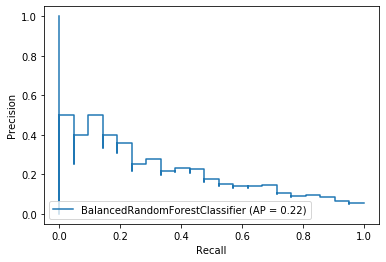

In [106]:
# gbc= BalancedRandomForestClassifier(n_estimators=5000, max_depth=10, random_state=0,oob_score = True)
# gbc.fit(X_training, Y_training)
# preds = gbc.predict_proba(X_test)
print(average_precision_score(Y_test, preds[:, 1]))

confusion = confusion_matrix(Y_test, gbc.predict(X_test))
print(confusion)

precision, recall, thresholds = precision_recall_curve(Y_test, preds[:, 1])
print(auc(recall, precision))

fpr_d2v, tpr_d2v, thresholds_d2v = metrics.roc_curve(Y_test, preds[:,1], pos_label=1)
accuracy_d2v = metrics.accuracy_score(Y_test, gbc.predict(X_test), normalize=True)


print("AUC: "+ str(metrics.auc(fpr_d2v, tpr_d2v)))
print("Accuracy: " + str(accuracy_d2v))

plot_precision_recall_curve(gbc, X_test, Y_test)

In [48]:
RFC = RandomForestClassifier(bootstrap=True,criterion='gini',max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=300,
            oob_score=False,
            random_state=1,
            verbose=0, warm_start=False, class_weight= 'balanced')
RFC = CalibratedClassifierCV(gbc, cv=5, method="sigmoid")
RFC.fit(X_training, Y_training)


preds = RFC.predict_proba(X_test)
probs = preds[:, 1].tolist()
precision, recall, thresholds = precision_recall_curve(Y_test, probs)

pr_auc = auc(recall, precision)

fpr_d2v, tpr_d2v, thresholds_d2v = metrics.roc_curve(Y_test, preds[:,1], pos_label=1)
accuracy_d2v = metrics.accuracy_score(Y_test, gbc.predict(X_test), normalize=True)


print("AUC: "+ str(metrics.auc(fpr_d2v, tpr_d2v)))
print("Accuracy: " + str(accuracy_d2v))
print(pr_auc)

predicted = RFC.predict(X_test)
confusion = confusion_matrix(Y_test, predicted)
print(confusion)

AUC: 0.822599531615925
Accuracy: 0.7642436149312377
0.19905816812643637
[[487   1]
 [ 20   1]]


In [49]:
learner = ActiveLearner(
    estimator= BalancedRandomForestClassifier(n_estimators=5000, max_depth=10, random_state=0,oob_score = True),
    query_strategy=entropy_sampling,
    X_training=X_training, y_training=Y_training
)

X_pool = np.asarray([model.docvecs[i] for i in clas_dat.index[clas_dat['label'].isnull()].tolist()])
query_idx, query_inst = learner.query(X_pool,10)
query_idx

array([19773, 29449, 14031, 25120, 25567,  1197, 15516, 43898, 51394,
       28380])

In [55]:
pd.options.display.max_colwidth = 2000
clas_dat.loc[query_idx, 'text']

clas_dat.loc[query_idx, 'label'] = 0
clas_dat.loc[query_idx, 'label']


19773    0.0
29449    0.0
14031    0.0
25120    0.0
25567    0.0
1197     0.0
15516    0.0
43898    0.0
51394    0.0
28380    0.0
Name: label, dtype: float64

In [107]:
# Define new training set
query_idx = [19773, 29449, 14031, 25120, 25567,  1197, 15516, 43898, 51394, 28380]
x_new_train = np.asarray([model.docvecs[i] for i in query_idx])
y_new_train = np.asarray(clas_dat.loc[query_idx, 'label'].tolist(), dtype="int")
X_training = np.append(X_training,x_new_train, axis = 0)
Y_training = np.append(Y_training,y_new_train, axis = 0)

print(X_training.shape)
Y_training

(2002, 150)


array([0, 0, 0, ..., 0, 0, 0])

0.22662337359433088
[[368 120]
 [  6  15]]
AUC: 0.814207650273224
Accuracy: 0.7524557956777996
0.20141821958721823


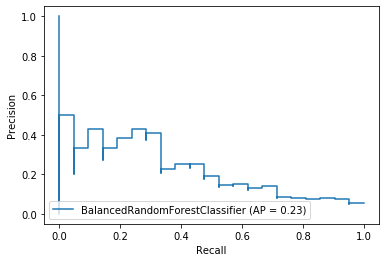

In [60]:
gbc= BalancedRandomForestClassifier(n_estimators=5000, max_depth=10, random_state=0,oob_score = True)
gbc.fit(X_training, Y_training)
preds = gbc.predict_proba(X_test)
print(average_precision_score(Y_test, preds[:, 1]))

confusion = confusion_matrix(Y_test, gbc.predict(X_test))
print(confusion)

fpr_d2v, tpr_d2v, thresholds_d2v = metrics.roc_curve(Y_test, preds[:,1], pos_label=1)
accuracy_d2v = metrics.accuracy_score(Y_test, gbc.predict(X_test), normalize=True)


print("AUC: "+ str(metrics.auc(fpr_d2v, tpr_d2v)))
print("Accuracy: " + str(accuracy_d2v))

precision, recall, thresholds = precision_recall_curve(Y_test, preds[:, 1])
print(auc(recall, precision))
plot_precision_recall_curve(gbc, X_test, Y_test)

In [58]:
RFC = RandomForestClassifier(bootstrap=True,criterion='gini',max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=300,
            oob_score=False,
            random_state=1,
            verbose=0, warm_start=False, class_weight= 'balanced')
RFC = CalibratedClassifierCV(gbc, cv=5, method="sigmoid")
RFC.fit(X_training, Y_training)


preds = RFC.predict_proba(X_test)
probs = preds[:, 1].tolist()
precision, recall, thresholds = precision_recall_curve(Y_test, probs)

pr_auc = auc(recall, precision)

fpr_d2v, tpr_d2v, thresholds_d2v = metrics.roc_curve(Y_test, preds[:,1], pos_label=1)
accuracy_d2v = metrics.accuracy_score(Y_test, gbc.predict(X_test), normalize=True)


print("AUC: "+ str(metrics.auc(fpr_d2v, tpr_d2v)))
print("Accuracy: " + str(accuracy_d2v))
print(pr_auc)

predicted = RFC.predict(X_test)
confusion = confusion_matrix(Y_test, predicted)
print(confusion)

AUC: 0.817720530835285
Accuracy: 0.7524557956777996
0.2022696805808572


NameError: name 'confu' is not defined

In [61]:
learner = ActiveLearner(
    estimator= BalancedRandomForestClassifier(n_estimators=5000, max_depth=10, random_state=0,oob_score = True),
    query_strategy=entropy_sampling,
    X_training=X_training, y_training=Y_training
)

X_pool = np.asarray([model.docvecs[i] for i in clas_dat.index[clas_dat['label'].isnull()].tolist()])
query_idx, query_inst = learner.query(X_pool,10)
query_idx

array([15662, 24447, 31125, 13287, 48025, 27314, 52547, 17549, 64200,
        9321])

In [64]:
pd.options.display.max_colwidth = 2000
clas_dat.loc[query_idx, 'text']

clas_dat.loc[query_idx, 'label'] = 0
clas_dat.loc[[48025, 9321], 'label'] = 1
clas_dat.loc[query_idx, 'label']


15662    0.0
24447    0.0
31125    0.0
13287    0.0
48025    1.0
27314    0.0
52547    0.0
17549    0.0
64200    0.0
9321     1.0
Name: label, dtype: float64

In [65]:
# Define new training set
x_new_train = np.asarray([model.docvecs[i] for i in query_idx.tolist()])
y_new_train = np.asarray(clas_dat.loc[query_idx, 'label'].tolist(), dtype="int")
X_training = np.append(X_training,x_new_train, axis = 0)
Y_training = np.append(Y_training,y_new_train, axis = 0)

print(X_training.shape)
Y_training

(2012, 150)


array([0, 0, 0, ..., 0, 0, 1])

0.21388518107124352
[[359 129]
 [  6  15]]
AUC: 0.820647931303669
Accuracy: 0.7347740667976425
0.18893500906758423


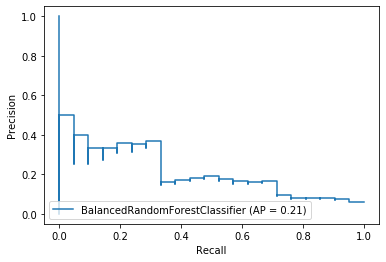

In [66]:
gbc= BalancedRandomForestClassifier(n_estimators=5000, max_depth=10, random_state=0,oob_score = True)
gbc.fit(X_training, Y_training)
preds = gbc.predict_proba(X_test)
print(average_precision_score(Y_test, preds[:, 1]))

confusion = confusion_matrix(Y_test, gbc.predict(X_test))
print(confusion)

fpr_d2v, tpr_d2v, thresholds_d2v = metrics.roc_curve(Y_test, preds[:,1], pos_label=1)
accuracy_d2v = metrics.accuracy_score(Y_test, gbc.predict(X_test), normalize=True)


print("AUC: "+ str(metrics.auc(fpr_d2v, tpr_d2v)))
print("Accuracy: " + str(accuracy_d2v))

precision, recall, thresholds = precision_recall_curve(Y_test, preds[:, 1])
print(auc(recall, precision))
plot_precision_recall_curve(gbc, X_test, Y_test)

In [67]:
RFC = RandomForestClassifier(bootstrap=True,criterion='gini',max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=300,
            oob_score=False,
            random_state=1,
            verbose=0, warm_start=False, class_weight= 'balanced')
RFC = CalibratedClassifierCV(gbc, cv=5, method="sigmoid")
RFC.fit(X_training, Y_training)


preds = RFC.predict_proba(X_test)
probs = preds[:, 1].tolist()
precision, recall, thresholds = precision_recall_curve(Y_test, probs)

pr_auc = auc(recall, precision)

fpr_d2v, tpr_d2v, thresholds_d2v = metrics.roc_curve(Y_test, preds[:,1], pos_label=1)
accuracy_d2v = metrics.accuracy_score(Y_test, gbc.predict(X_test), normalize=True)


print("AUC: "+ str(metrics.auc(fpr_d2v, tpr_d2v)))
print("Accuracy: " + str(accuracy_d2v))
print(pr_auc)

predicted = RFC.predict(X_test)
confusion = confusion_matrix(Y_test, predicted)
print(confusion)

AUC: 0.8231850117096019
Accuracy: 0.7347740667976425
0.20175294905869298
[[487   1]
 [ 20   1]]


In [76]:
# HAL
# re-initialize the training set 
X_training = np.asarray([model.docvecs[i] for i in clas_dat.index[clas_dat['test'] == 0].tolist()])
Y_training = np.asarray(clas_dat[clas_dat.test==0].label.tolist(), dtype="int")

In [242]:
# query_id = [73, 35982,  9758, 20826, 64942] 
explore = clas_dat.sample(n = 5, random_state = 0).index.tolist()
# query_id = [73, 35982,  9758, 20826, 64942] + explore

# clas_dat.loc[explore, 'text']

# clas_dat.loc[explore, 'label'] = 0

hal1 = clas_dat.loc[explore, ]

hal1

,total_id,text,label,test
64274,64274_24,"Over the last 3 years, our economy has grown at the fastest rate of any major industrialized nation. The homeownership rate in America is at an alltime high. Incomes are up. Farm incomes are up. The past 13 months, we've added 1.9 million new jobs. The unemployment rate across America is 5.4 percent. That's lower than the average of the 1970s, the 1980s, and the 1990s. The unemployment rate in the great State of Wisconsin is 4.8 percent.",0.0,NaN
54030,54030_15,"Audience members. You got it! The President. Say, I want to make this point. At our convention, I wasn't just asking for your vote. I was asking us to rally around an achievable set of goals for our country: goals in manufacturing and energy and education and national security and defense. Real, concrete goals that will lead to new jobs and more opportunity and rebuild this economy on a stronger foundation. That's what we can do in the next 4 years. That's why I'm running for a second term.",0.0,NaN
19693,19693_19,"Are these your goals? Is this your spirit? Is this the America that you want to produce, and that you want to see, and that you want to fight for?",0.0,NaN
64819,64819_45,"My opponent's plan would move America down the road to Federal control of health care, and that is the wrong road for American families. In all we do to improve health care in a new term, we will make sure the decisions are made by doctors and patients, not by officials in Washington, DC. The fourth clear choice in this election involves your retirement. Our Nation has made a solemn commitment to our seniors on Medicare and Social Security. When I ran for President 4 years ago, I promised to keep that commitment. I promised to improve Medicare by adding prescription drug coverage for our seniors. I kept my word. You remember those endless debates; leaders on both political parties have talked about strengthening Medicare for years. We got the job done. Seniors are now getting discounts on medicine through drug discount cards. Low-income seniors are getting $600 to help them this year and next year. And beginning in 2006, all seniors will be able to get prescription drug coverage under Medicare.",0.0,NaN
6793,6793_22,"For the source of all welfare in America, both government and private, is the American concept of freedom. Only in a free land such as ours is aid to the needy abundantly and freely given. Only in a land where people are free is the ability to live in dignity seen as a right for every person. Freedom, indeed, is the one area where America truly and significantly stands apart from the other powerful nations of the world.",0.0,NaN


In [80]:
# Define new training set
x_new_train = np.asarray([model.docvecs[i] for i in query_id])
y_new_train = np.asarray(clas_dat.loc[query_id, 'label'].tolist(), dtype="int")
X_training = np.append(X_training,x_new_train, axis = 0)
Y_training = np.append(Y_training,y_new_train, axis = 0)

print(X_training.shape)
Y_training

(1992, 150)


array([0, 0, 0, ..., 0, 0, 0])

0.22350433374266937
[[369 119]
 [  6  15]]
AUC: 0.8229898516783762
Accuracy: 0.7544204322200393
0.19802849394273642


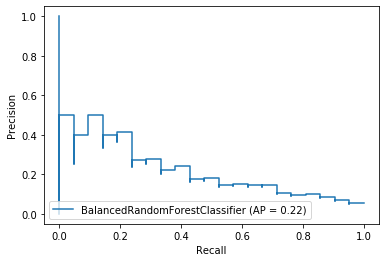

In [81]:
gbc= BalancedRandomForestClassifier(n_estimators=5000, max_depth=10, random_state=0,oob_score = True)
gbc.fit(X_training, Y_training)
preds = gbc.predict_proba(X_test)
print(average_precision_score(Y_test, preds[:, 1]))

confusion = confusion_matrix(Y_test, gbc.predict(X_test))
print(confusion)

fpr_d2v, tpr_d2v, thresholds_d2v = metrics.roc_curve(Y_test, preds[:,1], pos_label=1)
accuracy_d2v = metrics.accuracy_score(Y_test, gbc.predict(X_test), normalize=True)


print("AUC: "+ str(metrics.auc(fpr_d2v, tpr_d2v)))
print("Accuracy: " + str(accuracy_d2v))

precision, recall, thresholds = precision_recall_curve(Y_test, preds[:, 1])
print(auc(recall, precision))
plot_precision_recall_curve(gbc, X_test, Y_test)

In [87]:
# learner = ActiveLearner(
#     estimator= BalancedRandomForestClassifier(n_estimators=5000, max_depth=10, random_state=0,oob_score = True),
#     query_strategy=entropy_sampling,
#     X_training=X_training, y_training=Y_training
# )

# X_pool = np.asarray([model.docvecs[i] for i in clas_dat.index[clas_dat['label'].isnull()].tolist()])
query_id, query_inst = learner.query(X_pool,5)
query_id

array([29117,  4239, 17687, 17238, 54452])

In [243]:
explore = clas_dat.sample(n = 5, random_state = 1).index.tolist()
# query_id = query_id.tolist() + explore

# clas_dat.loc[query_id, 'text']

# clas_dat.loc[query_id, 'label'] = 0
# clas_dat.loc[54452, 'label'] = 1

# clas_dat.loc[query_id, 'label']

hal2 = clas_dat.loc[explore, ]

hal2

,total_id,text,label,test
45795,45795_30,"I know it's unfashionable to talk about faith, but I remember that cold day up in Camp David when we had to make this terrible decision about sending the sons and daughters of New Jersey into Desert Storm, into combat. And my experience in combat, the pride I felt in wearing the uniform of this country, made a difference in how I made that decision. On that cold day in Camp David, Barbara and I went to that little chapel, and yes, we prayed that I would do the right thing and that these young men and women would come home safe. And they did. They lifted up the morale of this country. They lifted the burden off the veterans of Vietnam. They raised with pride service to country. And I'll tell you something: It was a proud moment. And the press and the media are not going to distort it. It was decent and noble and made us the leader of the entire world.",0.0,NaN
37689,37689_3,That which unites us as American citizens is far greater than that which divides us as political parties. I urge you all to give General Eisenhower the support he will need to carry out the great tasks that lie before him. I pledge him mine.,0.0,NaN
70409,70409_56,"Number four, block funding for sanctuary cities. We block the funding. No more funds.",0.0,NaN
38367,38367_6,"When he became a candidate for the bench in 1953, the Chicago Bar Association termed him """"a man of ability, character, and integrity, well qualified to be a judge."""" He led the Bar Association poll and he led his party's ticket in the election. He has won everyone's respect as the wise and fair-minded Chief Justice of the Criminal Court of Cook County.",0.0,NaN
5114,5114_10,"As I said, we have an all-volunteer Army, Navy, Air Force, and Marines, and they are good, they are career people. And we are strong because we have the right weapons systems; good leadership, outstanding young people, and they are voluntary recruits. And I can say with great pride that the United States is at peace. Not a single young American is fighting or dying on any foreign battlefield tonight, and they won't.",0.0,NaN


In [92]:
# Define new training set
x_new_train = np.asarray([model.docvecs[i] for i in query_id])
y_new_train = np.asarray(clas_dat.loc[query_id, 'label'].tolist(), dtype="int")
X_training = np.append(X_training,x_new_train, axis = 0)
Y_training = np.append(Y_training,y_new_train, axis = 0)

print(X_training.shape)
Y_training

(2002, 150)


array([0, 0, 0, ..., 0, 0, 0])

0.23903745198260512
[[368 120]
 [  6  15]]
AUC: 0.8330405932864948
Accuracy: 0.7524557956777996
0.2132811276523604


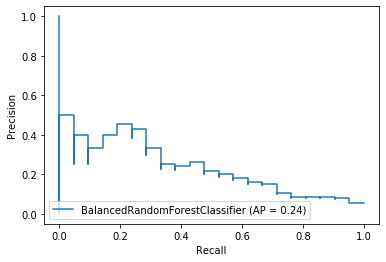

In [93]:
gbc= BalancedRandomForestClassifier(n_estimators=5000, max_depth=10, random_state=0,oob_score = True)
gbc.fit(X_training, Y_training)
preds = gbc.predict_proba(X_test)
print(average_precision_score(Y_test, preds[:, 1]))

confusion = confusion_matrix(Y_test, gbc.predict(X_test))
print(confusion)

fpr_d2v, tpr_d2v, thresholds_d2v = metrics.roc_curve(Y_test, preds[:,1], pos_label=1)
accuracy_d2v = metrics.accuracy_score(Y_test, gbc.predict(X_test), normalize=True)


print("AUC: "+ str(metrics.auc(fpr_d2v, tpr_d2v)))
print("Accuracy: " + str(accuracy_d2v))

precision, recall, thresholds = precision_recall_curve(Y_test, preds[:, 1])
print(auc(recall, precision))
plot_precision_recall_curve(gbc, X_test, Y_test)

In [97]:
# learner = ActiveLearner(
#     estimator= BalancedRandomForestClassifier(n_estimators=5000, max_depth=10, random_state=0,oob_score = True),
#     query_strategy=entropy_sampling,
#     X_training=X_training, y_training=Y_training
# )

# X_pool = np.asarray([model.docvecs[i] for i in clas_dat.index[clas_dat['label'].isnull()].tolist()])
query_id, query_inst = learner.query(X_pool,5)
query_id

array([ 3521, 31665, 54412, 28190,  9844])

In [244]:
explore = clas_dat.sample(n = 5, random_state = 2).index.tolist()
# query_id = query_id.tolist() + explore

# clas_dat.loc[query_id, 'text']

# clas_dat.loc[query_id, 'label'] = 0
# clas_dat.loc[[54412, 27842], 'label'] = 1

# clas_dat.loc[query_id, 'label']

hal3 = clas_dat.loc[explore,]

hal3

,total_id,text,label,test
48871,48871_13,"And you see, my friends, that is the way America got where it is today, not by weakening individuals, not by taking responsibility from our people, not by discouraging individual enterprise, not by weakening our states and our local governments, but by strengthening, by getting every bit of effort that we can out of each segment of the local American economy. That is why I say our programs will work where theirs won't. However, you have to take this into account: My opponent can say to you he is going to spend more money in health and education and welfare, in these various fields, than the programs that I advocate will cost. But I ask you to think for a moment. Some people will say since he is going to spend more than you will spend, that means that his programs are better. But think for a moment. He isn't going to be spending his money, but your money, and that makes a big difference.",0.0,NaN
13401,13401_9,"And so, you have now a great turning point in human affairs. The question that the American people must solemnly, quietly, looking deeply into their consciences, decide is this: do we want to change direction? Do we want to repudiate the leadership of the President? Do we want to move in another direction? Do we need the kind of leadership that our opponent offers?",0.0,NaN
27842,27842_5,"For too many years, the government has not given neighborhoods the only thing they need--a chance to make it on their own. No government that cared about our neighborhoods would stack the tax deck against them. A landlord can let a building run down and make a good living on the tax breaks. But when a homeowner spends a little hard earned money fixing up his house, the assessor raises his taxes.",1.0,NaN
50060,50060_15,"And we're on your side. Because we believe that every workplace in America, every workplace should be a quality workplace, a productive workplace, and a safe workplace. And beginning on January 20, of 1989, we're going to have an Occupational Safety and Health Administration, whose inspectors make those inspections as if their lives depend on it.",0.0,NaN
58999,58999_51,"The President. That sounded like a big one to me. You see, good tax policy says to businessowners, """"Invest,"""" because you know what investment means? Investment means jobs. And so in our tax policy we said to small-business owners that you're able to deduct up to $100,000 for equipment expensing in the year in which you buy it, as opposed to $25,000. And why did we do that? Because we want to encourage Eric to invest. And so he says he buys a 400-ton——",0.0,0.0


In [99]:
# Define new training set
x_new_train = np.asarray([model.docvecs[i] for i in query_id])
y_new_train = np.asarray(clas_dat.loc[query_id, 'label'].tolist(), dtype="int")
X_training = np.append(X_training,x_new_train, axis = 0)
Y_training = np.append(Y_training,y_new_train, axis = 0)

print(X_training.shape)
Y_training

(2012, 150)


array([0, 0, 0, ..., 1, 0, 0])

0.21830238595270957
[[373 115]
 [  6  15]]
AUC: 0.8288446526151444
Accuracy: 0.762278978388998
0.19346382884599597


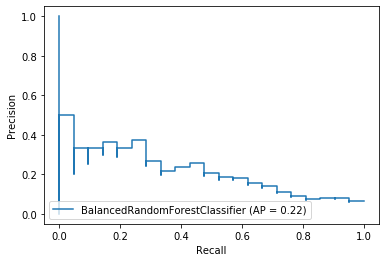

In [100]:
gbc= BalancedRandomForestClassifier(n_estimators=5000, max_depth=10, random_state=0,oob_score = True)
gbc.fit(X_training, Y_training)
preds = gbc.predict_proba(X_test)
print(average_precision_score(Y_test, preds[:, 1]))

confusion = confusion_matrix(Y_test, gbc.predict(X_test))
print(confusion)

fpr_d2v, tpr_d2v, thresholds_d2v = metrics.roc_curve(Y_test, preds[:,1], pos_label=1)
accuracy_d2v = metrics.accuracy_score(Y_test, gbc.predict(X_test), normalize=True)


print("AUC: "+ str(metrics.auc(fpr_d2v, tpr_d2v)))
print("Accuracy: " + str(accuracy_d2v))

precision, recall, thresholds = precision_recall_curve(Y_test, preds[:, 1])
print(auc(recall, precision))
plot_precision_recall_curve(gbc, X_test, Y_test)

In [119]:
sorted(metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [230]:
yuchen_anot = pd.read_csv("annotated_par_yuchen.csv")

yuchen_anot = yuchen_anot.loc[0:494, :]

yuchen_anot = yuchen_anot.drop('Unnamed: 0', axis=1)

yuchen_anot.to_csv('annotated_par_yuchen.csv')

In [231]:
al = pd.read_csv('20201115_all_paragraphs.csv')
al_before = pd.read_csv('20201110_all_paragraphs.csv')
print(len(al))
print(len(al_before))

71827
72379


In [245]:
hal = hal1.append(hal2.append(hal3))
hal.to_csv('HAL_random_annoations.csv')

In [255]:
duplicate = dat[dat.duplicated(['Speech_id', 'par_id'], keep = False)] 
duplicate[['Speech_id', 'par_id', 'text', 'label']]

,Speech_id,par_id,text,label
2383,1822,6,"And I say to you: you know what we can do. You know how we will react to Mr. Khrushchev or to anyone else because we have been through the test. Now let us look at our opponent for a moment. What do we know about him? First of all, we know something about him as far as this campaign is concerned. On three occasions during our debates the American people have had an opportunity to see how he would have made a decision differently from the way the President of the United States has made that decision, decisions affecting the security of his country. And, so, you must test him, as you test us, by that record.",0.0
2384,1822,6,"And I say to you: you know what we can do. You know how we will react to Mr. Khrushchev or to anyone else because we have been through the test. Now let us look at our opponent for a moment. What do we know about him? First of all, we know something about him as far as this campaign is concerned. On three occasions during our debates the American people have had an opportunity to see how he would have made a decision differently from the way the President of the United States has made that decision, decisions affecting the security of his country. And, so, you must test him, as you test us, by that record.",0.0
9649,2877,21,"But my opponent, as a senator, personally led the fight against having a shuttle program at all. He called it a horrible waste. Well, we support the space shuttle, and we've committed America to meet a great challenge--to build a manned space center out in space and to do it within a decade. What this country needs is high tech, not high taxes.",0.0
9650,2877,21,"But my opponent, as a senator, personally led the fight against having a shuttle program at all. He called it a horrible waste. Well, we support the space shuttle, and we've committed America to meet a great challenge--to build a manned space center out in space and to do it within a decade. What this country needs is high tech, not high taxes.",0.0
11841,2282,13,I believe that America does care. I believe that we would rather build hospitals that can cure the sick than a plane that cannot fly. I believe that we would rather end poverty in America than continue the killing in Asia.,0.0
...,...,...,...,...
67583,2016-10-24-manchester-new-hampshire,29,"What happened is trickle-down economics came back. So here is what I am going to do. We are going to ask the wealthy to finally pay their fair share. We are going to – we are going to close the loopholes, we are going to end the fact that millionaires can pay a lower tax rate than a nurse or a teacher or a police officer. We are going to make big banks pay for the risks they pose to our economy because Elizabeth is absolutely right. No – no bank is too big to fail, and no one should be above the law, and we are going to enforce that and contrast that with Donald Trump. He believes that if you give trillions and that is trillions with a 't' in tax cuts to the wealthy millionaires and billionaires and corporations, and everything will work out.",0.0
70593,2004-08-12-remarks-carson-california,0,"Over the last few weeks, John Edwards and I have made our way across this country we love, from sea to shining sea, because we believe in America and we believe we can do better. And at every stop we've made, from great cities to the great Southwest, from the flag-draped front porches of Main Street America to the small family farms that dot the Midwest, we've met Americans who believe that too. While millions are struggling to find work, and millions more are struggling to pay the bills, these folks hold on to an optimism that is both courageous and classically American. They know we can do better. They know our best days lie ahead. And they still believe in an America where a willingness to work hard is rewarded with the opportunity to earn a decent living and the chance to get ahead.",0.0
70594,2004-08-12-remarks-carson-california,0,"Over the last f

In [5]:
os.getcwd()

'/Users/yuchenluo/Desktop/Measure_RadicalDiscourse/codes'